In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import copy
import re
import time
from tqdm import tqdm
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F

from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, AutoConfig

In [2]:
class Config:
    bos_token = '<s>'
    eos_token = '</s>'
    usr_token = '<usr>'
    pad_token = '<pad>'
    sys_token = '<sys>'
    unk_token = '<unk>'
    mask_token = '<mask>'
    max_len = 512
    max_turns = 16
    epochs = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rate = 1e-4
    model_name = "skt/kogpt2-base-v2"

In [3]:
# data = pd.read_csv('./data/kakao_version.csv')
data = pd.read_csv('./data/kakao_len384.csv')

data

,conversation
0,<usr> 나 운전면허 따야 하는데<sys> 너 따긴 했잖아?연수를 받아야지 너는<...
1,<usr> 내일은 산에 못가시나요?<sys> 산에 못가고 장보러 가야지.휴양림가서 ...
2,<usr> 오늘 도서관가서 책 빌려왔음<sys> 오호 도서관도 가나? 어디도서관?<...
3,<usr> 파운데이션 하나 같이 테스트 하러 가자<sys> 오 파운데이션 다 썼어?...
4,<usr> 비긴 어게인 다시 보고 싶다<sys> 아 나는 그거 또보고싶다고!<usr...
...,...
62657,<usr> 나 방금 병원 다녀왔어 ㅠㅠ<sys> 병원? 어디 아파ㅠ?<usr> 목이...
62658,<usr> 영화볼 때 주인공 위주로 보는 편이야?<sys> 응 난 아무래도 주인공이...
62659,<usr> 포도가 요즘 맛있더라고요.<sys> 무슨 포도 드셨어요?<usr> 샤인머...
62660,<usr> 오늘 문화센터 특강한던데 한번 가볼래?<sys> 그거 등록해야하는거 아니...


In [4]:
S = 100

# data = pd.read_csv('./data/kakao_version_2.csv')
data = data[:S].reset_index(drop=True)
# data_train_val['conversation'] = data_train_val['conversation'].apply(lambda x: x.replace("키키", "ㅋㅋ"))
data['conversation'] = data['conversation'].apply(lambda x: x.replace("하하", "ㅎㅎ"))

In [5]:
data_train = data[:-10]
data_val = data[-10:]
data_train

,conversation
0,<usr> 나 운전면허 따야 하는데<sys> 너 따긴 했잖아?연수를 받아야지 너는<...
1,<usr> 내일은 산에 못가시나요?<sys> 산에 못가고 장보러 가야지.휴양림가서 ...
2,<usr> 오늘 도서관가서 책 빌려왔음<sys> 오호 도서관도 가나? 어디도서관?<...
3,<usr> 파운데이션 하나 같이 테스트 하러 가자<sys> 오 파운데이션 다 썼어?...
4,<usr> 비긴 어게인 다시 보고 싶다<sys> 아 나는 그거 또보고싶다고!<usr...
...,...
85,<usr> 나 오늘 차 계약했어.<sys> 어머. 내가 소개시켜준 딜러한테?<usr...
86,<usr> 가족 여행을 어디로 갈까나<sys> 오 아직도 못 정했어?<usr> 웅웅...
87,<usr> 나 보톡스 맞아볼려고!<sys> 그거 일회성이 아닌건 알고 있지? ㅋㅋ<...
88,<usr> 엄마 네일 한 지 좀 오래되지 않았어?<sys> 엄마는 원래 자주 안 해...


In [6]:
def token_split(dialogues):
    dials = re.split('<usr> |<sys> ', dialogues)
    dials = [dial.strip() for dial in dials if dial.strip()]
    
    return dials

In [7]:
print(data_train['conversation'][1])
print()
print(token_split(data_train['conversation'][1]))

<usr> 내일은 산에 못가시나요?<sys> 산에 못가고 장보러 가야지.휴양림가서 산책해야지만보 걸을수 있을런지 모르겠다.<usr> 그러게요 이번주는 걷기 어플 주간미션달성 아직인가요?<sys> 이번주 주간미션 달성했어.획득한 리워드가 기다리고 있어요.<usr> 이번주도 하셨네요걷기운동으로 커피쿠폰 또 받을 수 있겠어요<sys> 그래. 별것아닌것 같아도 보람이 있다.<usr> 네 만보걷기는 어플 채우는 재미도 큰 거 같아요<sys> 건강을 위해서 걷기하는데 만보 채우는 재미도 있어.<usr> 네 걷기운동 안하면 어플이 빈털털이 느낌이라 아쉬운감이 있어요<sys> 어플도 채우고 건강도 챙기고 네가 이런저런 어플 알려줘서 재미도 있고 보람도 있어.<usr> 엄마가 걸어서 모으신 포인트를 유 용하게 사용하셔야 더 재밌을텐데요빵도 사드시고 많이 모으면 치킨도 사드시고 하세요 ㅎㅎ<sys> 그냥 걸어도 건강해져서 좋은데 덤으로 생기는 포인트들이 있으니 더 좋아한달동안 걸어서 토스적립금도 재밌고오늘도 계좌로 입금했어.<usr> 매달 말일에 하면 잊지않고 좋겠네요

['내일은 산에 못가시나요?', '산에 못가고 장보러 가야지.휴양림가서 산책해야지만보 걸을수 있을런지 모르겠다.', '그러게요 이번주는 걷기 어플 주간미션달성 아직인가요?', '이번주 주간미션 달성했어.획득한 리워드가 기다리고 있어요.', '이번주도 하셨네요걷기운동으로 커피쿠폰 또 받을 수 있겠어요', '그래. 별것아닌것 같아도 보람이 있다.', '네 만보걷기는 어플 채우는 재미도 큰 거 같아요', '건강을 위해서 걷기하는데 만보 채우는 재미도 있어.', '네 걷기운동 안하면 어플이 빈털털이 느낌이라 아쉬운감이 있어요', '어플도 채우고 건강도 챙기고 네가 이런저런 어플 알려줘서 재미도 있고 보람도 있어.', '엄마가 걸어서 모으신 포인트를 유 용하게 사용하셔야 더 재밌을텐데요빵도 사드시고 많이 모으면 치킨도 사드시고 하세요 ㅎㅎ', '그냥 걸어도 건강해져서 좋은데 덤으로 생기는 포인트들이 있으니 더 좋아한달동

In [8]:
data_train['conversation'] = data_train['conversation'].apply(token_split)

data_train

/tmp/ipykernel_273/1909354095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['conversation'] = data_train['conversation'].apply(token_split)


,conversation
0,"[나 운전면허 따야 하는데, 너 따긴 했잖아?연수를 받아야지 너는, 맞아 연수를 길..."
1,"[내일은 산에 못가시나요?, 산에 못가고 장보러 가야지.휴양림가서 산책해야지만보 걸..."
2,"[오늘 도서관가서 책 빌려왔음, 오호 도서관도 가나? 어디도서관?, 거기 상인동에 ..."
3,"[파운데이션 하나 같이 테스트 하러 가자, 오 파운데이션 다 썼어?, 옹옹 파데는 ..."
4,"[비긴 어게인 다시 보고 싶다, 아 나는 그거 또보고싶다고!, ㅎㅎ 배우들 연기력이..."
...,...
85,"[나 오늘 차 계약했어., 어머. 내가 소개시켜준 딜러한테?, 응응 전화해봤는데 엄..."
86,"[가족 여행을 어디로 갈까나, 오 아직도 못 정했어?, 웅웅ㅜ 뭔가 우리가 정하기 ..."
87,"[나 보톡스 맞아볼려고!, 그거 일회성이 아닌건 알고 있지? ㅋㅋ, 알지 46개월 ..."
88,"[엄마 네일 한 지 좀 오래되지 않았어?, 엄마는 원래 자주 안 해서 괜찮아., 이..."


In [9]:
data_train = data_train.loc[data_train['conversation'].apply(lambda x: len(x) > 3)].reset_index(drop=True)

data_train

,conversation
0,"[나 운전면허 따야 하는데, 너 따긴 했잖아?연수를 받아야지 너는, 맞아 연수를 길..."
1,"[내일은 산에 못가시나요?, 산에 못가고 장보러 가야지.휴양림가서 산책해야지만보 걸..."
2,"[오늘 도서관가서 책 빌려왔음, 오호 도서관도 가나? 어디도서관?, 거기 상인동에 ..."
3,"[파운데이션 하나 같이 테스트 하러 가자, 오 파운데이션 다 썼어?, 옹옹 파데는 ..."
4,"[비긴 어게인 다시 보고 싶다, 아 나는 그거 또보고싶다고!, ㅎㅎ 배우들 연기력이..."
...,...
85,"[나 오늘 차 계약했어., 어머. 내가 소개시켜준 딜러한테?, 응응 전화해봤는데 엄..."
86,"[가족 여행을 어디로 갈까나, 오 아직도 못 정했어?, 웅웅ㅜ 뭔가 우리가 정하기 ..."
87,"[나 보톡스 맞아볼려고!, 그거 일회성이 아닌건 알고 있지? ㅋㅋ, 알지 46개월 ..."
88,"[엄마 네일 한 지 좀 오래되지 않았어?, 엄마는 원래 자주 안 해서 괜찮아., 이..."


In [10]:
data_val['conversation'] = data_val['conversation'].apply(token_split)
data_val = data_val.reset_index(drop=True)

data_val

/tmp/ipykernel_273/592510162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['conversation'] = data_val['conversation'].apply(token_split)


,conversation
0,"[그거 알아? sns 사용 시간 1위 국가가 필리핀이래., 아니. 처음 알았어. 넌..."
1,"[님은 다음 생에 결혼하실건가요?, 결혼하면 여자들 일만 늘어나는것 같지 않나요?,..."
2,"[가을이라 그런지 너무 외롭다., 그러고 보니 너만 여자친구가 없구나., 연애하는 ..."
3,"[마당에 잔디 깎아야되는데 언제할꺼야?, 나 이번주말에 별일 없으니깐 내가 할께!,..."
4,"[그리고 또 다른 내친구네 오빠가 고깃집을 하거든, 엉엉 맛있겟다 고기, 천안에서 ..."
5,"[서울 유명 사립대학교의 영어 유치원이 일을 냈네요., 또 무슨 사고를 쳤나요, 이..."
6,"[군대에서 담배 시작하는 애들이 많더라, 동기들과 어울리기 위해서일까?, 끊임없이 ..."
7,"[올드뎌 펜트하우스, 아 펜트하우스가 그래 좋나 ㅋㅋ빨리 치우고 정리해서 본방송 보..."
8,"[옛날에는 똥개라고 불렀었는데, 요새는 그말 진짜 안쓰잖아, 시고르자브종 이라고 부..."
9,"[뭔가 택배가 온듯바닥에 던지는 소리가 났다국밥 산거 왔는가?, 국밥 산느지 좀 됏..."


In [11]:
data_val = data_val.loc[data_val['conversation'].apply(lambda x: len(x) > 3)].reset_index(drop=True)

data_val

,conversation
0,"[그거 알아? sns 사용 시간 1위 국가가 필리핀이래., 아니. 처음 알았어. 넌..."
1,"[님은 다음 생에 결혼하실건가요?, 결혼하면 여자들 일만 늘어나는것 같지 않나요?,..."
2,"[가을이라 그런지 너무 외롭다., 그러고 보니 너만 여자친구가 없구나., 연애하는 ..."
3,"[마당에 잔디 깎아야되는데 언제할꺼야?, 나 이번주말에 별일 없으니깐 내가 할께!,..."
4,"[그리고 또 다른 내친구네 오빠가 고깃집을 하거든, 엉엉 맛있겟다 고기, 천안에서 ..."
5,"[서울 유명 사립대학교의 영어 유치원이 일을 냈네요., 또 무슨 사고를 쳤나요, 이..."
6,"[군대에서 담배 시작하는 애들이 많더라, 동기들과 어울리기 위해서일까?, 끊임없이 ..."
7,"[올드뎌 펜트하우스, 아 펜트하우스가 그래 좋나 ㅋㅋ빨리 치우고 정리해서 본방송 보..."
8,"[옛날에는 똥개라고 불렀었는데, 요새는 그말 진짜 안쓰잖아, 시고르자브종 이라고 부..."
9,"[뭔가 택배가 온듯바닥에 던지는 소리가 났다국밥 산거 왔는가?, 국밥 산느지 좀 됏..."


In [12]:
# tokenizer = PreTrainedTokenizerFast.from_pretrained(Config.model_name,
#             bos_token=Config.bos_token, eos_token=Config.eos_token, unk_token='<unk>',
#             pad_token=Config.pad_token, mask_token=Config.mask_token)

import sentencepiece as spm
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("SentencePiece_04.model")

True

In [13]:
test = """
<usr> 내일은 산에 못가시나요?<sys> 산에 못가고 장보러 가야지.휴양림가서 산책해야지만보 걸을수 있을런지 모르겠다.<usr> 그러게요 이번주는 걷기 어플 주간미션달성 아직인가요?<sys> 이번주 주간미션 달성했어.획득한 리워드가 기다리고 있어요.<usr> 이번주도 하셨네요걷기운동으로 커피쿠폰 또 받을 수 있겠어요<sys> 그래. 별것아닌것 같아도 보람이 있다.<usr> 네 만보걷기는 어플 채우는 재미도 큰 거 같아요<sys> 건강을 위해서 걷기하는데 만보 채우는 재미도 있어.<usr> 네 걷기운동 안하면 어플이 빈털털이 느낌이라 아쉬운감이 있어요<sys> 어플도 채우고 건강도 챙기고 네가 이런저런 어플 알려줘서 재미도 있고 보람도 있어.<usr> 엄마가 걸어서 모으신 포인트를 유 용하게 사용하셔야 더 재밌을텐데요빵도 사드시고 많이 모으면 치킨도 사드시고 하세요 ㅎㅎ<sys> 그냥 걸어도 건강해져서 좋은데 덤으로 생기는 포인트들이 있으니 더 좋아한달동안 걸어서 토스적립금도 재밌고오늘도 계좌로 입금했어.<usr> 매달 말일에 하면 잊지않고 좋겠네요
"""
tokenizer.encode(test)

[49186,
 4,
 1888,
 13917,
 17938,
 16875,
 49199,
 5,
 13917,
 73,
 1447,
 16752,
 1668,
 49189,
 49534,
 49462,
 49524,
 712,
 1763,
 1248,
 38370,
 8965,
 49247,
 558,
 27064,
 2773,
 49189,
 4,
 39210,
 354,
 650,
 10594,
 1822,
 9872,
 49291,
 49782,
 49371,
 49394,
 213,
 4524,
 49199,
 5,
 354,
 49239,
 9872,
 49291,
 49782,
 22930,
 437,
 49189,
 49978,
 49805,
 49222,
 640,
 49344,
 3715,
 3992,
 2051,
 49189,
 4,
 354,
 1270,
 4595,
 798,
 50047,
 49208,
 3542,
 83,
 744,
 24009,
 158,
 1560,
 42,
 20,
 3139,
 5,
 47,
 49189,
 324,
 49309,
 49190,
 49557,
 49309,
 9290,
 19489,
 729,
 49189,
 4,
 117,
 72,
 49223,
 50047,
 674,
 1822,
 24287,
 25515,
 522,
 11,
 2772,
 5,
 14589,
 5339,
 10594,
 701,
 72,
 49223,
 24287,
 25515,
 179,
 49189,
 4,
 117,
 10594,
 3542,
 8675,
 18850,
 2387,
 49907,
 29907,
 13150,
 13317,
 3230,
 2051,
 5,
 29635,
 13866,
 1200,
 49203,
 8949,
 3859,
 16596,
 1822,
 12251,
 25515,
 826,
 10721,
 49203,
 179,
 49189,
 4,
 589,
 4618,
 3608,
 493

In [14]:
# 데이터셋
# 전처리 후, 텀을 나눠놓은 상태의 데이터를 입력으로 받음
class CustomDataset(Dataset):
    """
        입력 : 전처리 후 대화 분리까지 완료된 데이터
            ex) ["밥 먹었어?", "응 밥 먹었어", "뭐 먹었어?", "샌드위치 먹었어"]
        출력 : 패딩까지 완료된 input_ids, token_type_ids, labels
    """
    def __init__(self, data, tokenizer, Config):
        self.data = data
        self.usr_token = Config.usr_token
        self.sys_token = Config.sys_token
        self.bos_token = Config.bos_token
        self.eos_token = Config.eos_token
        self.mask_token = Config.mask_token
        self.pad_token = Config.pad_token
        self.max_len = Config.max_len
        self.max_turns = Config.max_turns
        
        self.input_ids = []
        self.token_type_ids = []
        self.labels = []
        
        for i in tqdm(range(len(self.data))):
            hists = []
            dials = self.data[i]
            
            for u, utter in enumerate(dials):
                if u % 2 == 0:
                    hists.append(self.usr_token + utter)  # Speaker 1: User
                else:
                    hists.append(self.sys_token + utter)  # Speaker 2: System
            
            max_turn = max(len(hists), self.max_turns) # max_turns을 넘으면 post
            if max_turn % 2 != 0: max_turn -= 1 # user 대화로 끝남 방지
                
            for f in range(max_turn, 1, -2):
                contexts = hists[:f]
                if sum([len(l) for l in contexts]) > self.max_len-2: continue # bos_token와 eos_token 토큰을 추가하기 위해 -2
                contexts[0] = self.bos_token + contexts[0]
                contexts[-1] = contexts[-1] + self.eos_token
                contexts = [tokenizer.encode(ctx) for ctx in contexts]
                
                token_type_id = [[ctx[0]] * len(ctx) if c != 0 else [ctx[1]] * len(ctx) for c, ctx in enumerate(contexts)]
                label = [[-100] * len(ctx) if c != len(contexts)-1 else [-100] + ctx[1:] for c, ctx in enumerate(contexts)]
                
                input_id = list(chain.from_iterable(contexts))
                token_type_id = list(chain.from_iterable(token_type_id))
                label = list(chain.from_iterable(label))
                
                assert len(input_id) == len(token_type_id) == len(label), "There is something wrong in dialogue process."
                
                input_id, token_type_id, label = self.make_padding(input_id, token_type_id, label)
                
                self.input_ids.append(input_id)
                self.token_type_ids.append(token_type_id)
                self.labels.append(label)
                
                break
    
    def make_padding(self, input_id, token_type_id, label):
        left = self.max_len - len(input_id)
        
#         input_id += [tokenizer.pad_token_id] * left
#         token_type_id += [tokenizer.pad_token_id] * left
        input_id += [tokenizer.pad_id()] * left
        token_type_id += [tokenizer.pad_id()] * left
        label += [-100] * left
        
        return input_id, token_type_id, label
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.token_type_ids[idx], self.labels[idx]
    

In [15]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

In [16]:
#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_set = CustomDataset(data_train['conversation'], tokenizer, Config)
train_dataloader = DataLoader(train_set, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_batch,)

100%|██████████| 90/90 [00:00<00:00, 3780.28it/s]


In [17]:
for batch_idx, samples in enumerate(train_dataloader):
    if batch_idx > 0:
        break
    token_ids, mask, label = samples
    print("token_ids ====> ", token_ids)
    print("mask =====> ", mask)
    print("label =====> ", label)
    print(samples)

token_ids ====>  tensor([[49186,     2,     4,  ...,     0,     0,     0],
        [49186,     2,     4,  ...,     0,     0,     0],
        [49186,     2,     4,  ...,     0,     0,     0],
        [49186,     2,     4,  ...,     0,     0,     0],
        [49186,     2,     4,  ...,     0,     0,     0],
        [49186,     2,     4,  ...,     0,     0,     0]])
mask =====>  tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
label =====>  tensor([[-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]])
(tensor([[49186,     2,     4,  ...,     0,     0,     0],
        [49186,     2,     4, 

In [18]:
val_set = CustomDataset(data_val['conversation'], tokenizer, Config)
val_dataloader = DataLoader(val_set, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_batch,)

100%|██████████| 10/10 [00:00<00:00, 2259.62it/s]


In [19]:
tokenizer.bos_id(), tokenizer.eos_id()

(-1, -1)

In [20]:
model = GPT2LMHeadModel.from_pretrained(Config.model_name)

In [21]:
cfg = AutoConfig.from_pretrained(Config.model_name)
cfg

GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "created_date": "2021-04-28",
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "license": "CC-BY-NC-SA 4.0",
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.11.3",
  "

In [22]:
class ChatBot:
    """
        __init__ : 챗봇 모델 생성
            Args : model, tokenizer, Config
        
        train : 모델 학습 진행
            Args : epochs, train_data, (validation_data), (save)
        
        load_model : 모델 불러오기
            Args : PATH
        
        save_model : 모델 저장하기
            Args : PATH
        
        talk : 챗봇 대화하기
            대화 종료 멘트 : quit
    """
    
    def __init__(self, model, tokenizer, Config):
        """
            Args : model, tokenizer, Config
        """
        self.model = model
        self.tokenizer = tokenizer
        self.device = Config.device
        self.name = Config.model_name
        self.optim = torch.optim.Adam(model.parameters(), lr=Config.learning_rate)
        
#         self.user_token_id = tokenizer.get_vocab()[Config.usr_token]
#         self.bot_token_id = tokenizer.get_vocab()[Config.sys_token]
        self.user_token_id = tokenizer.PieceToId(Config.usr_token)
        self.bot_token_id = tokenizer.PieceToId(Config.sys_token)
        self.max_len = Config.max_len
        self.max_turns = Config.max_turns
        
        self.losses = []
        self.val_losses = []
    
    def train(self, epochs, train_data, validation_data=None, save=None):
        """
            epochs, train_data, validation_data=None, save=None
            save : epoch마다 모델을 저장할 경로/파일명
        """
        self.model.to(self.device)
        for epoch in range(epochs):
            self.model.train()
            print(f"\n Epoch {epoch+1}/{epochs}", sep="\n")
            starttime = time.time()
            batch_loss = []

            for i, batch in enumerate(train_data):
                input_ids, token_type_ids, labels = batch
                input_ids, token_type_ids, labels = \
                    input_ids.to(self.device), token_type_ids.to(self.device), labels.to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    token_type_ids = token_type_ids,
                    labels = labels
                )
                
                loss, logits = outputs[0], outputs[1]
                
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                batch_loss.append(loss.item())
                
                print(self.status(i+1, len(train_data), time.time()-starttime, np.mean(batch_loss)), end='\r')

            self.losses.append(np.mean(batch_loss))
            
            if validation_data:
                val_loss = self.validation(validation_data)
                print(self.status(i+1, len(train_data), time.time()-starttime, np.mean(batch_loss)) + \
                      " | val_loss : %.6f"%(val_loss), end='\r')
                self.val_losses.append(val_loss)
            
            if save:
                PATH = f'{save}_epochs-{epoch+1}_loss-{np.mean(batch_loss)}.pth'
                torch.save(self.model.state_dict(), PATH)
                
    def validation(self, validation_data):
        self.model.eval()
        batch_loss = []
        
        with torch.no_grad():
            for i, batch in enumerate(validation_data):
                input_ids, token_type_ids, labels = batch
                input_ids, token_type_ids, labels = \
                    input_ids.to(self.device), token_type_ids.to(self.device), labels.to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    token_type_ids = token_type_ids,
                    labels = labels
                )
                
                loss, logits = outputs[0], outputs[1]
                batch_loss.append(loss.item())
            
            valid_loss = np.mean(batch_loss)
        
        return valid_loss

    @staticmethod
    def status(step, step_len, time, loss):
        return "step : %d/%d - %ds | loss : %.6f | %.2fit/s"%(
            step,
            step_len,
            int(time),
            loss,
            step/time
        )
    
    def load_model(self, PATH):
        """
            PATH : pth 파일이 저장된 경로
        """
        self.model.load_state_dict(torch.load(PATH))
        print("model loaded.")
    
    def save_model(self, PATH=None):
        """
            PATH : 저장할 파일 경로/이름, 생략시 모델 이름과 현재 시간을 파일명으로 지정함
        """
        if not PATH:
            name = self.name.replace("/", "-")
            PATH = f"./{name}_{time.strftime('%Y-%m-%d %H:%M:%S')}.pth"
        torch.save(self.model.state_dict(), PATH)
        print("model saved.")
    
    def talk(self):
        print("Escape ment : quit")
        with torch.no_grad():
            cur_speaker = 1
            input_ids_list = []
            token_type_ids_list = []
            t = 0
            output_id = None

            while True:
                if cur_speaker == 1:
                    cur_speaker_id = self.user_token_id
                    utter = input("You: ")

                    if utter == "quit":
                        print("Bot: Good bye.")
                        break

                    input_id = [cur_speaker_id] + self.tokenizer.encode(utter)

                    if t == 0:
#                         input_id = [self.tokenizer.bos_token_id] + input_id
                        input_id = [self.tokenizer.bos_id()] + input_id
                else:
                    cur_speaker_id = self.bot_token_id
                    input_id = copy.deepcopy(output_id)

                token_type_id = [cur_speaker_id] * len(input_id)

#                 if input_id[-1] == self.tokenizer.eos_token_id:
                if input_id[-1] == self.tokenizer.eos_id():
                    input_id = input_id[:-1]
                    token_type_id = token_type_id[:-1] 

                input_ids_list.append(input_id)
                token_type_ids_list.append(token_type_id)

                if t >= self.max_turns:
                    input_ids_list = input_ids_list[1:]
                    token_type_ids_list = token_type_ids_list[1:]

                next_speaker = (cur_speaker % 2) + 1
                if next_speaker == 1:
                    next_speaker_id = self.user_token_id
                else:
                    next_speaker_id = self.bot_token_id

                if cur_speaker == 1:
                    output_id = self.nucleus_sampling(input_ids_list, token_type_ids_list, next_speaker_id)
                    res = self.tokenizer.decode(output_id)

                    print(f"Bot: {res}")

                cur_speaker = copy.deepcopy(next_speaker)
                t += 1

    def nucleus_sampling(self, input_ids_list, token_type_ids_list, next_speaker_id):
        output_id = []
        res_id = [next_speaker_id]
        res_type_id = [next_speaker_id]
        
        for pos in range(self.max_len):
            input_ids = list(chain.from_iterable(input_ids_list)) + res_id
            token_type_ids = list(chain.from_iterable(token_type_ids_list)) + res_type_id
            input_len = len(input_ids)

            left = self.max_len - len(input_ids)
#             input_ids += [self.tokenizer.pad_token_id] * left
#             token_type_ids += [self.tokenizer.pad_token_id] * left
            input_ids += [self.tokenizer.pad_id()] * left
            token_type_ids += [self.tokenizer.pad_id()] * left

            assert len(input_ids) == len(token_type_ids), "There is something wrong in dialogue process."

            input_ids = torch.LongTensor(input_ids).unsqueeze(0).to(self.device)  # (1, L)
            token_type_ids = torch.LongTensor(token_type_ids).unsqueeze(0).to(self.device)  # (1, L)
            output = self.model(input_ids=input_ids, token_type_ids=token_type_ids)

            output = self.model(input_ids=input_ids, token_type_ids=token_type_ids)[0][:, input_len-1]  # (1, vocab_size)
            output = F.softmax(output, dim=-1)  # (1, vocab_size)

            sorted_probs, sorted_idxs = torch.sort(output, descending=True)
            cumsum_probs = torch.cumsum(sorted_probs, dim=-1)  # (1, vocab_size)
            idx_remove = cumsum_probs > 0.9
            sorted_probs[idx_remove] = 1e-8
            sorted_probs /= torch.sum(sorted_probs, dim=-1, keepdim=True)  # (1, vocab_size)

            # Random sampling
            probs = torch.zeros(output.shape).to(self.device).scatter_(-1, sorted_idxs, sorted_probs)  # (1, vocab_size)
            idx = torch.multinomial(probs, 1).squeeze(-1).squeeze(0).item()

#             if len(output_id) == self.max_len or idx == self.tokenizer.eos_token_id:
            if len(output_id) == self.max_len or idx == self.tokenizer.eos_id():
                break
            else:
                output_id.append(idx)
                res_id.append(idx)
                res_type_id.append(next_speaker_id)

        return output_id

In [23]:
prototype = ChatBot(model, tokenizer, Config)

In [24]:
prototype.train(Config.epochs, train_dataloader, val_dataloader)
prototype.load_model("skt-kogpt2-base-v2_2023-02-02 19:30:05.pth")


 Epoch 1/1
model loaded.- 13s | loss : 11.748104 | 1.11it/s | val_loss : 9.981423


In [25]:
# model.save_pretrained('models/temp.pt')
# prototype.save_model()

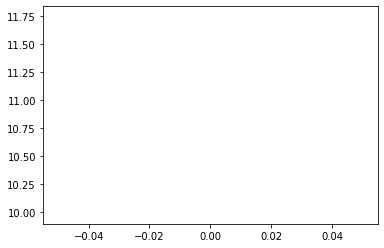

In [26]:
plt.plot(prototype.losses)
plt.plot(prototype.val_losses)
plt.show()

In [27]:
prototype.talk()

Escape ment : quit
You: 안녕 ㅋㅋ


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
!nvidia-smi

In [ ]:
tokenizer.unk_id()